In [5]:
import torch
import wandb
import numpy as np
from u_net import U_Net
import matplotlib.pyplot as plt
from data import get_data, view
import segmentation_models_pytorch as smp
from loops import training_loop, performance_report

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mkwambetumelo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

#### * * * * * RETRIEVE DATA * * * * #####

In [7]:
training_data = get_data('train', [2, 7, 10, 12, 21, 24, 27, 28, 30, 43])
validation_data = get_data('val', [1, 11, 22, 32])
testing_data = get_data('test', [4, 16, 29, 36])

#### * * * * * HELPER FUNCTIONS * * * * #####

In [9]:
def validation_plots(run_id):

    api = wandb.Api()
    run = api.run(f"computer-vision-wits/U-Net/{run_id}")
    history = run.history()

    plt.figure(figsize=(10, 6))
    plt.plot(history['Training Loss'], label='Training Loss')
    plt.plot(history['Validation Loss'], label='Validation Loss')
    plt.plot(history['Validation IoU'], label='Validation IoU')
    plt.title('Loss & IoU over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/IoU')
    plt.ylim(0, 2)
    plt.legend()
    plt.grid(True)
    plt.show()


def best_model_report(model, testing_data, model_name):

    loss, accuracy, precision, recall, f1, iou = performance_report(model = model, data = testing_data, batch_size = 1, device = "cpu")

    print(f"Performance Report of Best {model_name} Model By Validation IoU")
    print(f"Loss: {loss} | IoU: {iou} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1} \n")


def predict_masks(model, testing_data, device = "cpu"):

    model = model.to(device)
    model.eval()
    predicted_masks = []

    with torch.no_grad():
        for image, _ in testing_data:
            image = image.to(device).unsqueeze(0)
            out_image = model(image)
            out_image = torch.argmax(out_image, dim=1)
            out_image = out_image.squeeze(0).cpu()
            predicted_masks.append(out_image)

    return predicted_masks


def display_masks(masks, cmap = 'binary'):

    num_masks = len(masks)
    fig, axes = plt.subplots(1, num_masks, figsize = (num_masks * 3, 4))

    if num_masks == 1:
        axes = [axes]

    for i, mask in enumerate(masks):
        ax = axes[i]

        if cmap and len(mask.shape) == 2:
            ax.imshow(mask, cmap=cmap)
        else:
            ax.imshow(mask)

        ax.axis("off")

    plt.tight_layout()
    plt.show()

#### * * * * * U-NET BASIC ARCHITECTURE EXPERIMENTS * * * * * ####

In [11]:
unet_base = U_Net(in_channels = 3, out_channels = 2, start_channels = 64, depth = 4, bilinear = False)
unet_base = training_loop(model = unet_base, training_data = training_data, validation_data = validation_data, run_name = "unet_base", batch = 2, learning_rate = 1e-3, num_epochs = 15, device = device)

torch.torch.cuda.empty_cache()

Epoch: 0
Training | Loss: 0.6186984062194825
Validation | Loss: 0.4699554890394211 | IoU: 0.0 | Accuracy: 0.7605050404866537 | Precision: 0.0 | Recall: 0.0 | F1: 0.0 

Epoch: 1
Training | Loss: 0.5480202555656433
Validation | Loss: 0.4617820978164673 | IoU: 0.0 | Accuracy: 0.7605050404866537 | Precision: 0.0 | Recall: 0.0 | F1: 0.0 

Epoch: 2
Training | Loss: 0.5428636789321899
Validation | Loss: 0.5472078919410706 | IoU: 0.0 | Accuracy: 0.7605050404866537 | Precision: 0.0 | Recall: 0.0 | F1: 0.0 

Epoch: 3
Training | Loss: 0.5234127819538117
Validation | Loss: 0.41057804226875305 | IoU: 0.0 | Accuracy: 0.7605050404866537 | Precision: 0.0 | Recall: 0.0 | F1: 0.0 

Epoch: 4
Training | Loss: 0.5258348941802978
Validation | Loss: 0.3552808612585068 | IoU: 0.0 | Accuracy: 0.7605050404866537 | Precision: 0.0 | Recall: 0.0 | F1: 0.0 

Epoch: 5
Training | Loss: 0.4507076680660248
Validation | Loss: 0.3386905640363693 | IoU: 0.0 | Accuracy: 0.7605050404866537 | Precision: 0.0 | Recall: 0.0 | F

Training Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
Validation Accuracy,▆▆▆▆▆▆▆██████▁▆
Validation F1,▁▁▁▁▁▁▁▇█████▄▁
Validation IoU,▁▁▁▁▁▁▁▇█████▃▁
Validation Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁█▁
Validation Precision,▁▁▁▁▁▁▁██████▃█
Validation Recall,▁▁▁▁▁▁▁▇███▇██▁
Training Loss,5.56239
Validation Accuracy,0.76391
Validation F1,0.02805
Validation IoU,0.01422


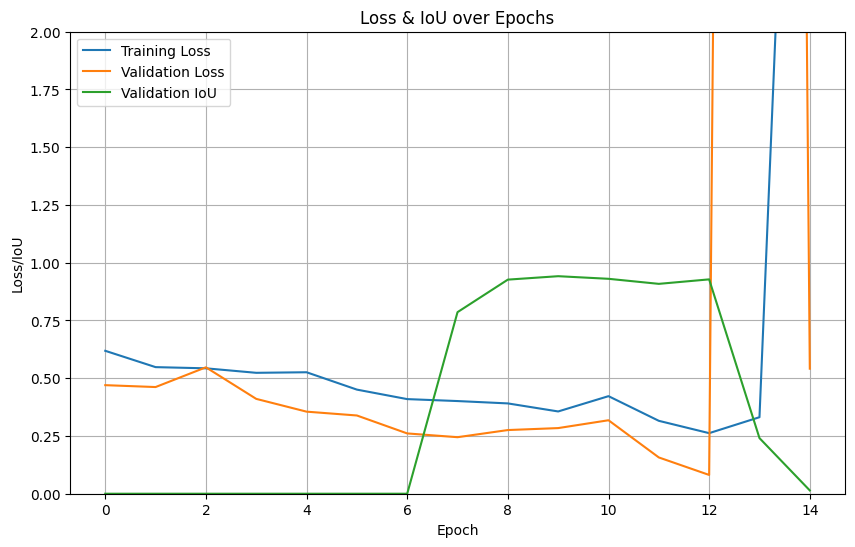

In [12]:
validation_plots("lfsmudwa")

Performance Report of Best U-Net Base Model By Validation IoU
Loss: 0.2750707156956196 | IoU: 0.9252275096703789 | Accuracy: 0.9804836908976237 | Precision: 0.9776610654171208 | Recall: 0.9452100643767746 | F1: 0.9611617380522351 



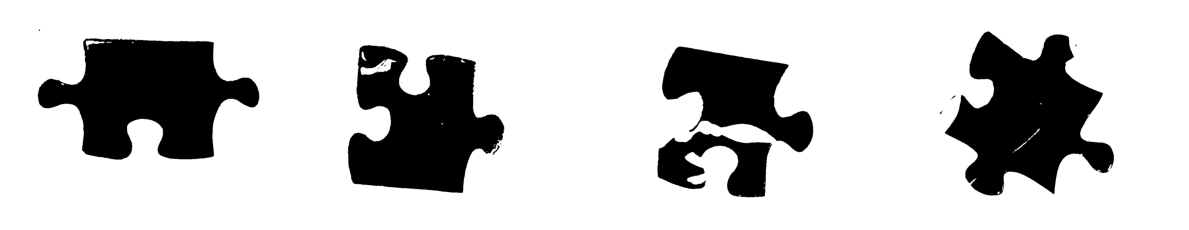

In [13]:
best_model_report(model = unet_base, testing_data = testing_data, model_name = "U-Net Base")

predicted_masks = predict_masks(model = unet_base, testing_data = testing_data, device = "cpu")
display_masks(masks = predicted_masks)

#### * * * * * U-NET BACKBONE ARCHITECTURES EXPERIMENTS * * * * * ####

In [15]:
# U-Net with ResNet Backbone
unet_res = smp.Unet(encoder_name = "resnet34", encoder_weights = "imagenet", in_channels = 3, classes = 2)
unet_res = training_loop(model = unet_res, training_data = training_data, validation_data = validation_data, run_name = "unet_res", batch = 2, learning_rate = 1e-3, num_epochs = 15, device = device)

torch.torch.cuda.empty_cache()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Epoch: 0
Training | Loss: 0.6144362270832062
Validation | Loss: 41.894113540649414 | IoU: 0.23949534018093774 | Accuracy: 0.23949654897054037 | Precision: 0.23949534018093774 | Recall: 1.0 | F1: 0.38644008156735293 

Epoch: 1
Training | Loss: 0.2965705156326294
Validation | Loss: 25.47296142578125 | IoU: 0.2397893481135096 | Accuracy: 0.24072265625 | Precision: 0.2397893481135096 | Recall: 1.0 | F1: 0.3868227267452786 

Epoch: 2
Training | Loss: 0.2147136390209198
Validation | Loss: 18.428297996520996 | IoU: 0.2398079718056469 | Accuracy: 0.24080022176106772 | Precision: 0.2398079718056469 | Recall: 1.0 | F1: 0.38684695897928834 

Epoch: 3
Training | Loss: 0.1670767843723297
Validation | Loss: 3.7956546545028687 | IoU: 0.26841333092934905 | Accuracy: 0.35118675231933594 | Precision: 0.2688530652544655 | Recall: 0.9939433437839301 | F1: 0.4232269156816355 

Epoch: 4
Training | Loss: 0.13627811521291733
Validation | Loss: 4.7853991985321045 | IoU: 0.18995601651320104 | Accuracy: 0.206642

Training Loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▂▁▄█▂▂▅█████
Validation F1,▂▂▂▂▁▃▇▂▂▄▇███▇
Validation IoU,▁▂▂▂▁▂▇▂▂▃▇▇██▇
Validation Loss,█▅▄▂▂▁▁▂▂▁▁▁▁▁▁
Validation Precision,▁▁▁▂▁▂▆▁▂▃▇▇██▇
Validation Recall,████▁▇▇█▇▇▇▇▇▇█
Training Loss,0.03099
Validation Accuracy,0.93884
Validation F1,0.88542
Validation IoU,0.7944


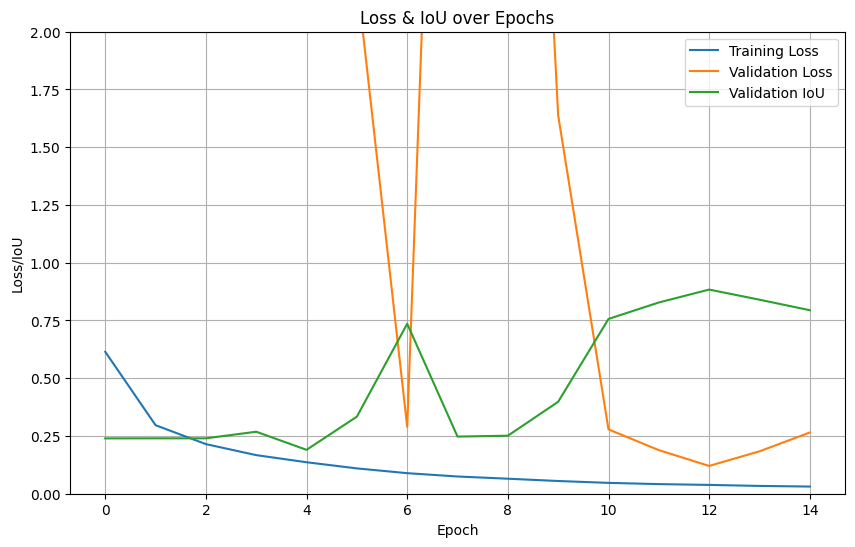

In [16]:
validation_plots("oijusiey")

Performance Report of Best U-Net ResNet Model By Validation IoU
Loss: 0.037605855613946915 | IoU: 0.9831235835864796 | Accuracy: 0.9956607818603516 | Precision: 0.9936085349487558 | Recall: 0.9893804450881293 | F1: 0.9914899824936783 



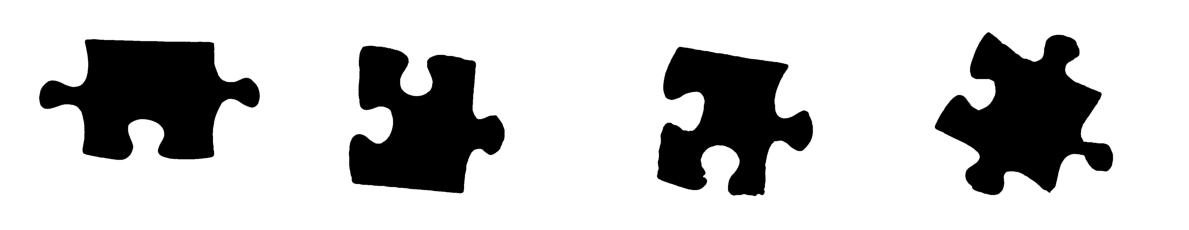

In [17]:
best_model_report(model = unet_res, testing_data = testing_data, model_name = "U-Net ResNet")

predicted_masks = predict_masks(model = unet_res, testing_data = testing_data, device = "cpu")
display_masks(masks = predicted_masks)

In [19]:
# U-Net with EfficientNet Backbone
unet_eff = smp.Unet(encoder_name = "efficientnet-b0", encoder_weights = "imagenet", in_channels = 3, classes = 2)
unet_eff = training_loop(model = unet_eff, training_data = training_data, validation_data = validation_data, run_name = "unet_eff", batch = 2, learning_rate = 1e-3, num_epochs = 15, device = device)

torch.torch.cuda.empty_cache()

Epoch: 0
Training | Loss: 0.41051300168037413
Validation | Loss: 13.70973539352417 | IoU: 0.23949526404732266 | Accuracy: 0.23949623107910156 | Precision: 0.23949526404732266 | Recall: 1.0 | F1: 0.3864399824575352 

Epoch: 1
Training | Loss: 0.13492144048213958
Validation | Loss: 2.8637046813964844 | IoU: 0.27032032215552587 | Accuracy: 0.46228790283203125 | Precision: 0.28595529408758286 | Recall: 0.831763531576111 | F1: 0.4255939505035021 

Epoch: 2
Training | Loss: 0.07625450938940048
Validation | Loss: 0.5234272480010986 | IoU: 0.2979377641992704 | Accuracy: 0.7966289520263672 | Precision: 0.6323343084462166 | Recall: 0.3603650718224124 | F1: 0.4590940681706346 

Epoch: 3
Training | Loss: 0.05559754818677902
Validation | Loss: 0.7174806892871857 | IoU: 0.08029502705488276 | Accuracy: 0.7730652491251627 | Precision: 0.7320381963612446 | Recall: 0.08272651734967201 | F1: 0.14865388628842313 

Epoch: 4
Training | Loss: 0.04599619582295418
Validation | Loss: 0.7380242645740509 | IoU: 0

Training Loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▂▄██▇███▆▅▃▂▂▁▁
Validation F1,▇▇█▂▃▃▇▄▁▁▁▁▁▁▂
Validation IoU,▆▇█▂▃▃▇▃▁▁▁▁▁▁▁
Validation Loss,█▂▁▁▁▁▁▁▁▁▂▂▂▃▄
Validation Precision,▃▃▇█▃▇██▂▁▁▁▁▁▁
Validation Recall,█▇▃▁▂▁▃▁▁▁▂▂▂▂▂
Training Loss,0.01072
Validation Accuracy,0.12913
Validation F1,0.1269
Validation IoU,0.06775


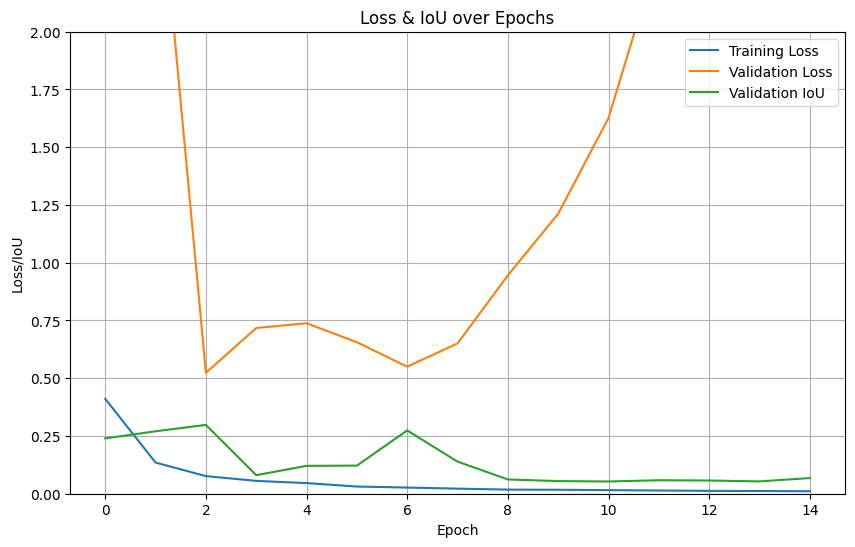

In [20]:
validation_plots("ednjuzbo")

Performance Report of Best U-Net EfficientNet Model By Validation IoU
Loss: 0.46382351219654083 | IoU: 0.30527952862189983 | Accuracy: 0.8118460973103842 | Precision: 0.8434780916676666 | Recall: 0.3236121168686062 | F1: 0.4677611529604095 



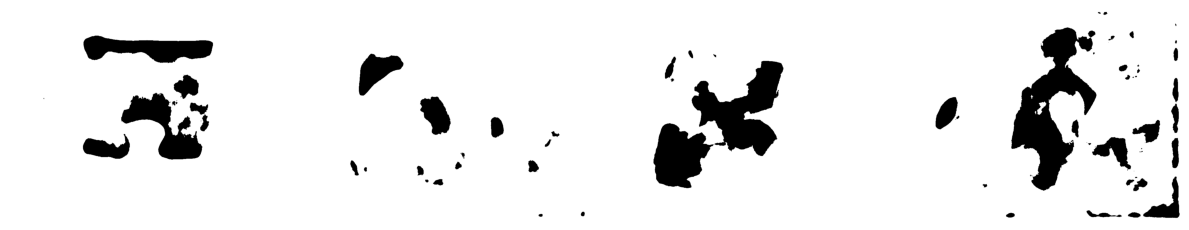

In [21]:
best_model_report(model = unet_eff, testing_data = testing_data, model_name = "U-Net EfficientNet")

predicted_masks = predict_masks(model = unet_eff, testing_data = testing_data, device = "cpu")
display_masks(masks = predicted_masks)

In [36]:
# U-Net with MobileNet V2 Backbone
unet_mobile = smp.Unet(encoder_name = "mobilenet_v2", encoder_weights = "imagenet", in_channels = 3, classes = 2)
unet_mobile = training_loop(model = unet_mobile, training_data = training_data, validation_data = validation_data, run_name = "unet_mobile", batch = 2, learning_rate = 1e-3, num_epochs = 15, device = device)

torch.torch.cuda.empty_cache()

Epoch: 0
Training | Loss: 0.5814690172672272
Validation | Loss: 2.1219762563705444 | IoU: 0.3269291575212461 | Accuracy: 0.5357904434204102 | Precision: 0.3337106589790095 | Recall: 0.9414788700612966 | F1: 0.4927605300827998 

Epoch: 1
Training | Loss: 0.27012551128864287
Validation | Loss: 14.860779762268066 | IoU: 0.2420196131404893 | Accuracy: 0.24992656707763672 | Precision: 0.2420196131404893 | Recall: 1.0 | F1: 0.3897194707393298 

Epoch: 2
Training | Loss: 0.17605186998844147
Validation | Loss: 9.225513458251953 | IoU: 0.24700097141698976 | Accuracy: 0.2701180775960286 | Precision: 0.2470205765204112 | Recall: 0.9996787835186743 | F1: 0.3961520112311029 

Epoch: 3
Training | Loss: 0.11198901236057282
Validation | Loss: 3.271090507507324 | IoU: 0.2980746625336121 | Accuracy: 0.4362195332845052 | Precision: 0.29810581081541093 | Recall: 0.999649582020372 | F1: 0.45925657612301446 

Epoch: 4
Training | Loss: 0.08046471923589707
Validation | Loss: 0.08590289950370789 | IoU: 0.94317

Training Loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
Validation Accuracy,▄▁▁▃███████████
Validation F1,▂▁▁▂███████████
Validation IoU,▂▁▁▂███████████
Validation Loss,▂█▅▃▁▁▁▁▁▁▁▁▁▁▁
Validation Precision,▂▁▁▂███████████
Validation Recall,▁███▅▁▂▄▄▅▅▆▆▆▇
Training Loss,0.01474
Validation Accuracy,0.99603
Validation F1,0.99168
Validation IoU,0.98349


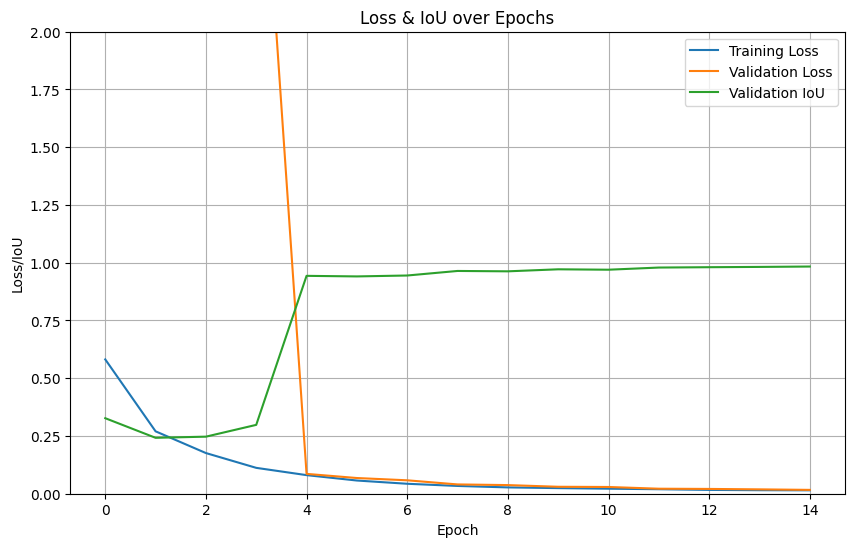

In [37]:
validation_plots("v6h4660z")

Performance Report of Best U-Net MobileNet Model By Validation IoU
Loss: 0.014985529473051429 | IoU: 0.9869996519533345 | Accuracy: 0.9966634114583334 | Precision: 0.9954317422088532 | Recall: 0.9914906694736633 | F1: 0.9934572972703415 



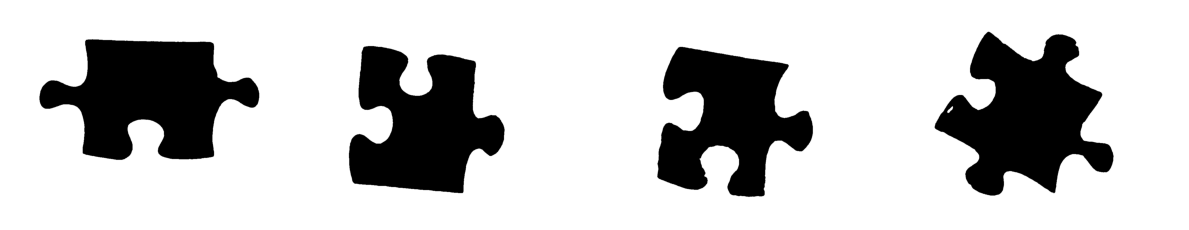

In [38]:
best_model_report(model = unet_mobile, testing_data = testing_data, model_name = "U-Net MobileNet")

predicted_masks = predict_masks(model = unet_mobile, testing_data = testing_data, device = "cpu")
display_masks(masks = predicted_masks)

#### * * * * * DEEPLAB V3+ BACKBONE ARCHITECTURES EXPERIMENTS * * * * * ####

In [26]:
# DeepLab V3+ with ResNet Backbone
deep_res = smp.DeepLabV3Plus(encoder_name = "resnet34", encoder_weights = "imagenet", in_channels = 3, classes = 2)
deep_res = training_loop(model = deep_res, training_data = training_data, validation_data = validation_data, run_name = "deep_res", batch = 2, learning_rate = 1e-3, num_epochs = 15, device = device)

torch.torch.cuda.empty_cache()

Epoch: 0
Training | Loss: 0.3899060755968094
Validation | Loss: 1.826698124408722 | IoU: 0.23949572084973925 | Accuracy: 0.23949813842773438 | Precision: 0.23949572084973925 | Recall: 1.0 | F1: 0.38644057711720436 

Epoch: 1
Training | Loss: 0.13108876943588257
Validation | Loss: 0.7134445011615753 | IoU: 0.3116140960027269 | Accuracy: 0.5108013153076172 | Precision: 0.31973410148866815 | Recall: 0.9246428789491709 | F1: 0.4751612489563837 

Epoch: 2
Training | Loss: 0.06651202589273453
Validation | Loss: 0.9369657933712006 | IoU: 0.3083820988854594 | Accuracy: 0.49005126953125 | Precision: 0.3135343810327022 | Recall: 0.9494084041912114 | F1: 0.47139455537973746 

Epoch: 3
Training | Loss: 0.04735690355300903
Validation | Loss: 0.5957326889038086 | IoU: 0.393550571128878 | Accuracy: 0.6531833012898763 | Precision: 0.40373862687009754 | Recall: 0.9397440355939718 | F1: 0.5648170640984679 

Epoch: 4
Training | Loss: 0.029641137272119523
Validation | Loss: 0.532258927822113 | IoU: 0.4450

Training Loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▃▅▆▆▇████████
Validation F1,▁▂▂▃▄▅▆▇███████
Validation IoU,▁▂▂▂▃▄▅▇███████
Validation Loss,█▄▅▃▃▂▂▁▁▁▁▁▁▁▁
Validation Precision,▁▂▂▃▃▄▅▇█████▇█
Validation Recall,█▄▅▄▁▅▆▇▇▇▇▇▇▇▇
Training Loss,0.01003
Validation Accuracy,0.99519
Validation F1,0.98993
Validation IoU,0.98006


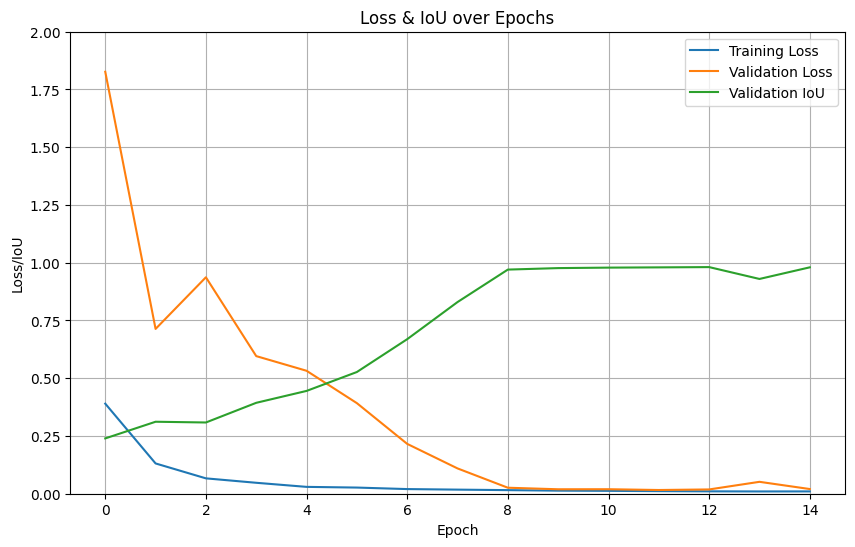

In [27]:
validation_plots("43qeqvvx")

Performance Report of Best DeepLab ResNet Model By Validation IoU
Loss: 0.014340995345264673 | IoU: 0.9810968532132023 | Accuracy: 0.9951232274373373 | Precision: 0.9902346689152299 | Recall: 0.9906819160240188 | F1: 0.9904582419803766 



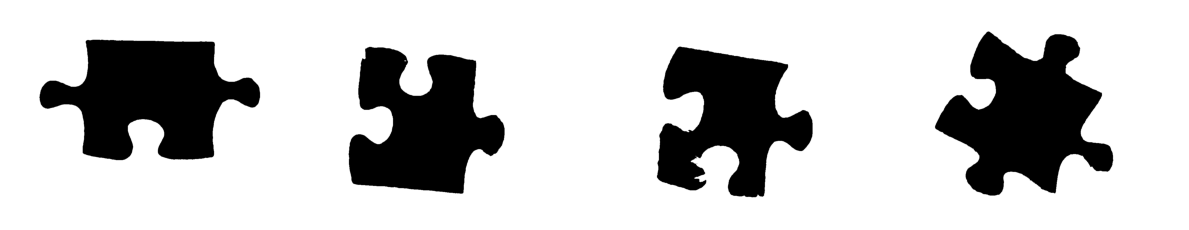

In [28]:
best_model_report(model = deep_res, testing_data = testing_data, model_name = "DeepLab ResNet")

predicted_masks = predict_masks(model = deep_res, testing_data = testing_data, device = "cpu")
display_masks(masks = predicted_masks)

In [29]:
# DeepLab V3+ with EfficientNet Backbone
deep_eff = smp.DeepLabV3Plus(encoder_name = "efficientnet-b0", encoder_weights = "imagenet", in_channels = 3, classes = 2)
deep_eff = training_loop(model = deep_eff, training_data = training_data, validation_data = validation_data, run_name = "deep_eff", batch = 2, learning_rate = 1e-3, num_epochs = 15, device = device)

torch.torch.cuda.empty_cache()

Epoch: 0
Training | Loss: 0.37949585616588594
Validation | Loss: 0.600038081407547 | IoU: 0.7964591849352984 | Accuracy: 0.9440129597981771 | Precision: 0.8603156333639596 | Recall: 0.9147515350696721 | F1: 0.8866988925929691 

Epoch: 1
Training | Loss: 0.08978893309831619
Validation | Loss: 0.44913727045059204 | IoU: 0.7336945619396925 | Accuracy: 0.9210844039916992 | Precision: 0.7927510446308005 | Recall: 0.90782414326786 | F1: 0.8463942588812416 

Epoch: 2
Training | Loss: 0.06193419992923736
Validation | Loss: 0.28822509944438934 | IoU: 0.7294625498401819 | Accuracy: 0.9269231160481771 | Precision: 0.865492078652156 | Recall: 0.8227336318965311 | F1: 0.8435713741330692 

Epoch: 3
Training | Loss: 0.0507049597799778
Validation | Loss: 0.15199416875839233 | IoU: 0.8094691385239958 | Accuracy: 0.9524672826131185 | Precision: 0.9529063933002425 | Recall: 0.8432012275248013 | F1: 0.8947034478679077 

Epoch: 4
Training | Loss: 0.04085099473595619
Validation | Loss: 0.20384526997804642 |

Training Loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,█▇▇█▇▇▇▇▆▆▅▄▃▃▁
Validation F1,████▇▇▇▇▇▆▆▄▂▁▁
Validation IoU,█▇▇█▇▆▆▆▆▅▅▃▁▁▁
Validation Loss,▅▄▂▁▁▂▂▂▂▃▄▅▇██
Validation Precision,▇▇▇██▇▇▇▇▇▇▇▆▃▁
Validation Recall,██▇▇▇▆▆▆▆▅▅▃▁▁▁
Training Loss,0.01416
Validation Accuracy,0.69031
Validation F1,0.02399
Validation IoU,0.01214


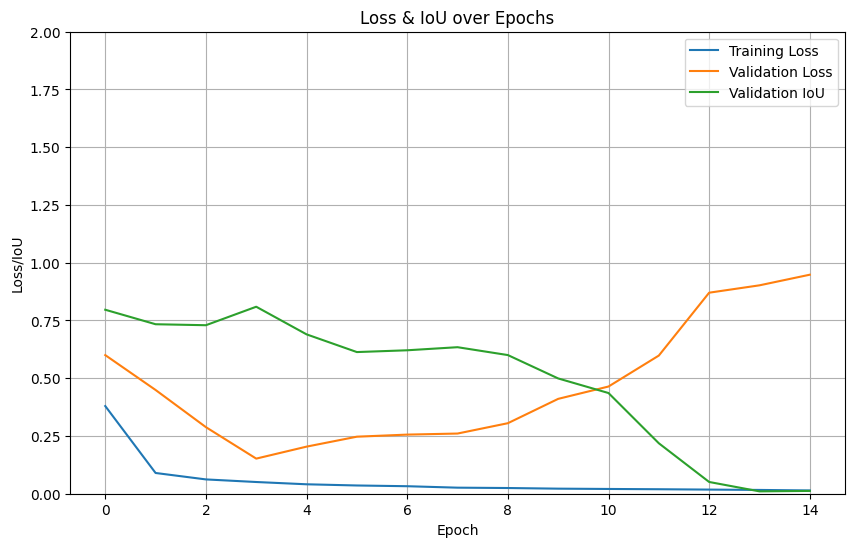

In [30]:
validation_plots("smywa2hg")

Performance Report of Best DeepLab EfficientNet Model By Validation IoU
Loss: 0.26096073910593987 | IoU: 0.6176216478991536 | Accuracy: 0.8989823659261068 | Precision: 0.9494276856599557 | Recall: 0.6386315393937584 | F1: 0.7636169418247766 



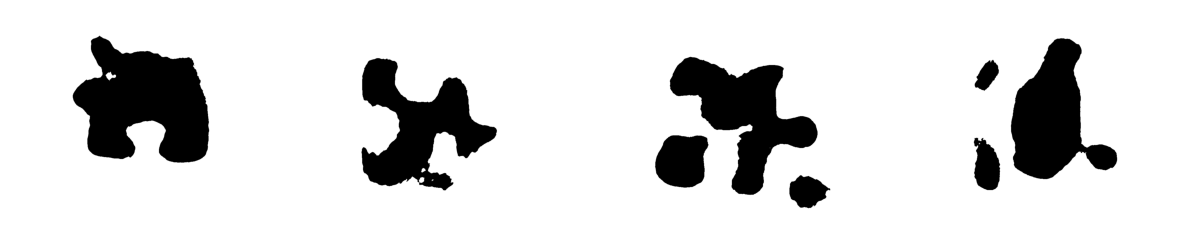

In [31]:
best_model_report(model = deep_eff, testing_data = testing_data, model_name = "DeepLab EfficientNet")

predicted_masks = predict_masks(model = deep_eff, testing_data = testing_data, device = "cpu")
display_masks(masks = predicted_masks)

In [ ]:
# DeepLab V3+ with DenseNet Backbone Does Not Support Dilation

In [33]:
# DeepLab V3+ with MobileNet V2 Backbone
deep_mobile = smp.DeepLabV3Plus(encoder_name = "mobilenet_v2", encoder_weights = "imagenet", in_channels = 3,classes = 2)
deep_mobile = training_loop(model = deep_mobile, training_data = training_data, validation_data = validation_data, run_name = "deep_mobile", batch = 2, learning_rate = 1e-3, num_epochs = 15, device = device)

torch.torch.cuda.empty_cache()

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Epoch: 0
Training | Loss: 0.3579895794391632
Validation | Loss: 0.8909348249435425 | IoU: 0.24106986580280093 | Accuracy: 0.24602794647216797 | Precision: 0.24106986580280093 | Recall: 1.0 | F1: 0.388487179401237 

Epoch: 1
Training | Loss: 0.10036319047212601
Validation | Loss: 2.821358799934387 | IoU: 0.2397583659212188 | Accuracy: 0.24059359232584634 | Precision: 0.2397583659212188 | Recall: 1.0 | F1: 0.38678241262451685 

Epoch: 2
Training | Loss: 0.07230345085263253
Validation | Loss: 3.824968695640564 | IoU: 0.25035448714093117 | Accuracy: 0.2828715642293294 | Precision: 0.25035448714093117 | Recall: 1.0 | F1: 0.4004536148998728 

Epoch: 3
Training | Loss: 0.04875173345208168
Validation | Loss: 1.596925973892212 | IoU: 0.34277837870798844 | Accuracy: 0.5408830642700195 | Precision: 0.34279772184791535 | Recall: 0.9998354097368414 | F1: 0.5105509354980936 

Epoch: 4
Training | Loss: 0.03966159522533417
Validation | Loss: 0.5546263754367828 | IoU: 0.49861688799130194 | Accuracy: 0.

Training Loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▄▆▇█████████
Validation F1,▁▁▁▂▄▆█████████
Validation IoU,▁▁▁▂▃▆▇████████
Validation Loss,▃▆█▄▂▁▁▁▁▁▁▁▁▁▁
Validation Precision,▁▁▁▂▃▆▇████████
Validation Recall,████▇▁▄▃▅▄▅▅▅▅▅
Training Loss,0.01195
Validation Accuracy,0.99422
Validation F1,0.98783
Validation IoU,0.97595


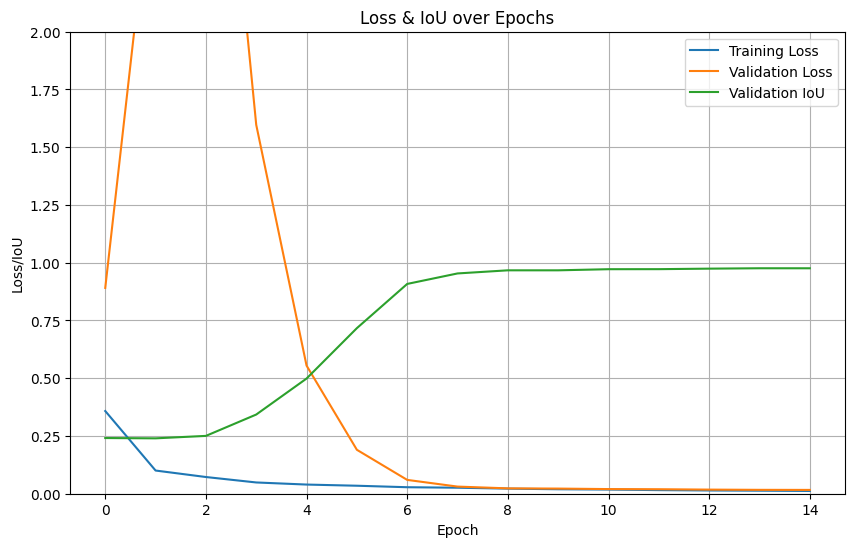

In [34]:
validation_plots("f0z3wblj")

Performance Report of Best DeepLab MobileNet Model By Validation IoU
Loss: 0.014828940387815237 | IoU: 0.979592819220177 | Accuracy: 0.994744618733724 | Precision: 0.9919985099552987 | Recall: 0.9873946443102328 | F1: 0.9896912230729035 



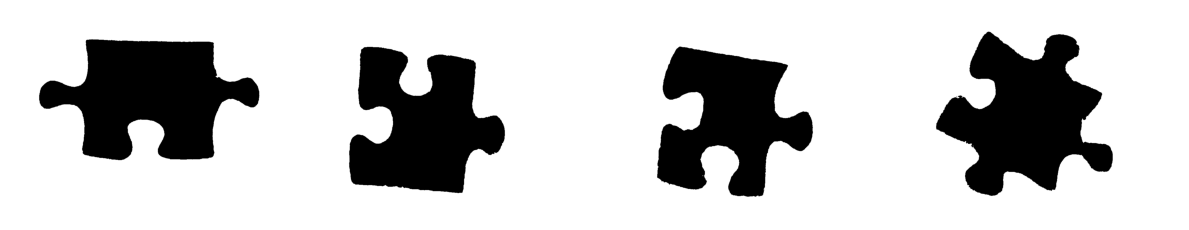

In [35]:
best_model_report(model = deep_mobile, testing_data = testing_data, model_name = "DeepLab MobileNet")

predicted_masks = predict_masks(model = deep_mobile, testing_data = testing_data, device = "cpu")
display_masks(masks = predicted_masks)